<center>
    <h1> INF393 - Maquinas de Aprendizaje  </h1>
    <h2> Tarea 3: Métodos No Lineales para Clasificación </h2>
    <h5> Alumnos: Ignacio Espinoza & Daniel Rivera</h5>
</center>

<h2> PARTE 1: El Viejo XOR </h2>
<p> Para esta sección se analizarán distintos modelos lineales y no-lineales sobre un problema conocido en el mundo de máquinas de aprendizaje, el <i> XOR Problem </i>. Para ello primero necesitamos generar el dataset, en donde también se introducirá ruido a un sector específico de los datos.

<h3> Creación y Visualización de Dataset </h3>


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

def do_XOR( n = 1000 , noisy_n = 100, svm = True):
   rng = np.random.RandomState(0)
   X_train = rng.uniform( low = -1.0 , high = 1.0 , size = (n,2))

   Y_train = np.logical_xor( X_train[:,0] > 0 , X_train[:,1] > 0 )
   Y_train = 2*Y_train -1 if svm else Y_train

   X_noisy= rng.uniform( low = -0.8, high = 0.2, size=( noisy_n , 2 ) )
   
   Y_noisy = -1*np.logical_xor(X_noisy[:,0] > 0, X_noisy[:,1] > 0) + 1
   Y_noisy = 2*Y_noisy -1 if svm else Y_noisy

   X_train = np.vstack((X_train, X_noisy))
   Y_train = np.hstack((Y_train, Y_noisy))

   X_test = rng.uniform( low = -1.0 , high = 1.0, size = (n,2) )
   Y_test = np.logical_xor( X_test[:,0] > 0, X_test[:,1] > 0)
   Y_test = 2*Y_test - 1 if svm else Y_test

   return X_train,Y_train,X_test,Y_test

Using Theano backend.


In [2]:
def plot_set(X,y,title):
   cmap = plt.cm.get_cmap('terrain')
   mclasses = (-1,1)
   mcolors = [cmap(i) for i in np.linspace(0,1,2)]
   plt.figure(figsize = (16,12))
   for lab, col in zip(mclasses,mcolors):
      plt.scatter(X[y == lab, 0] ,X[y == lab , 1], label = lab, c = col, s = 30)
   leg = plt.legend(loc= 'upper right', fancybox= True)
   plt.title(title)
   plt.show()

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


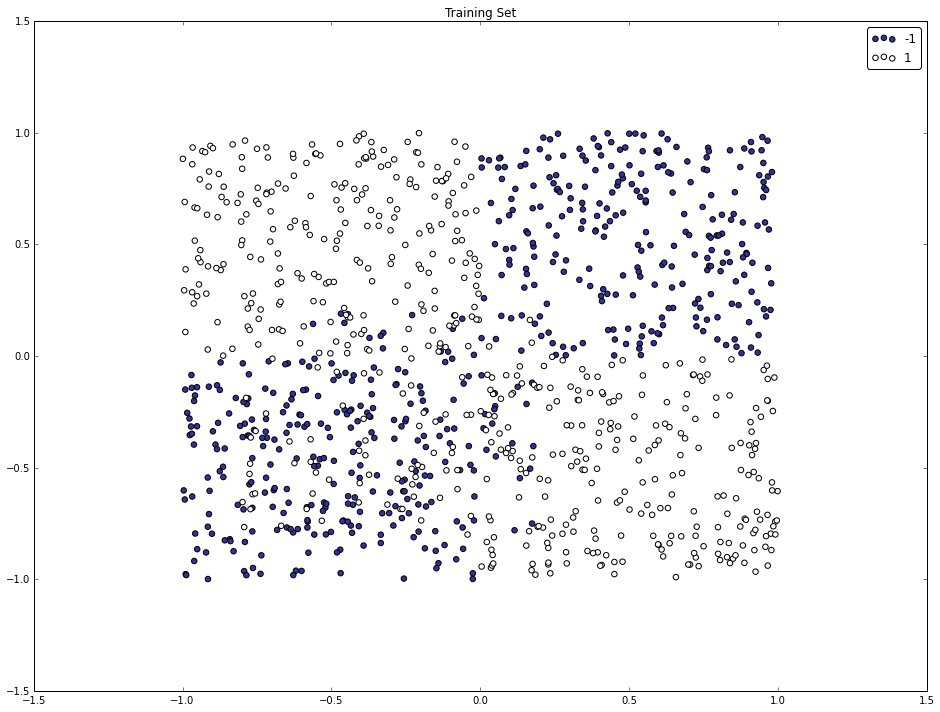

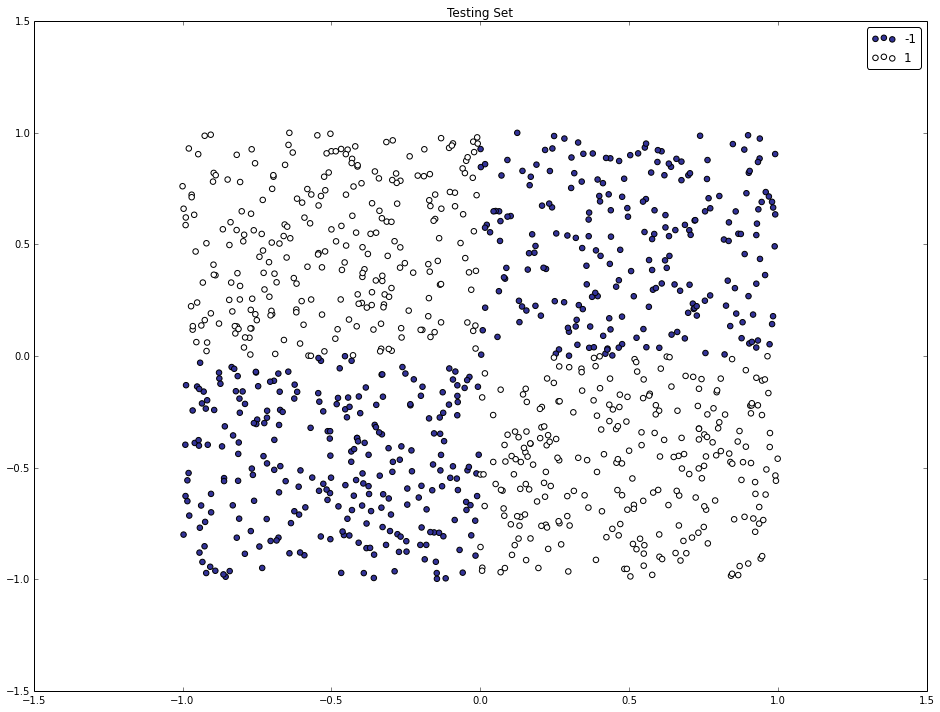

In [3]:
X_train,Y_train,X_test,Y_test = do_XOR()

plot_set(X_train,Y_train,"Training Set")

plot_set(X_test,Y_test,"Testing Set")

<p>Como se observa tanto en el set de entrenamiento como de prueba, hay una distribución uniforme de datos con 2 clases, de modo que la clasificación de estos datos asemeja al problema original de <b>XOR</b>, en donde hay una disyunción lógica, donde si un elemento posee tanto el eje $x$ y el eje $y$ del mismo signo (positivo o negativo) se la asigna la clase $-1$, y clase $1$ para el caso contrario.La característica mas importante es que ambas clases no pueden ser separadas con una linea recta simple. </p>

<table style="width:15%">
    <tr>
        <th>X</th>
        <th>Y</th>
        <th>Clase</th>
    </tr>
    <tr>
        <td>Positivo</td>
        <td>Positivo</td>
        <td>-1</td>
    </tr>
    <tr>
        <td>Negativo</td>
        <td>Negativo</td>
        <td>-1</td>
    </tr>
    <tr>
        <td>Positivo</td>
        <td>Negativo</td>
        <td>1</td>
    </tr>
    <tr>
        <td>Negativo</td>
        <td>Positivo</td>
        <td>1</td>
    </tr>
</table>

In [4]:
def plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type):
   f, axis = plt.subplots(1, 1, sharex = 'col', sharey = 'row', figsize = (15, 15))
   axis.scatter(X_train[:,0],X_train[:,1], s = 20, c = Y_train, zorder = 10,cmap = 'gray')
   axis.scatter(X_test[:,0],X_test[:,1], s = 20, c = Y_test, zorder = 10,cmap = 'gray')
   
   XX, YY = np.mgrid[-1:1:200j, -1:1:200j]

   if model_type == 'svm':
      Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
   elif model_type == 'tree':
      Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
   elif model_type == 'ann':
      Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
   else: raise ValueError('model type not supported')
   Z = Z.reshape(XX.shape)
   Zplot = Z > 0 if model_type == 'svm' else Z > 0.5
   
   axis.pcolormesh(XX, YY, Zplot , cmap = 'Blues')
   axis.contour(XX, YY, Z , alpha = 1 , colors= '#F44336', linestyles=['solid'], linewidths = 2, levels = [-1, 0, 1])
   plt.show()

def get_model_performance(clf,X_train,Y_train,X_test,Y_test,model_type):
   print clf.score(X_train,Y_train)
   print clf.score(X_test,Y_test)
   print classification_report(Y_test , clf.predict(X_test), target_names = ['-1','1'])

<h3> Análisis SVM Lineal </h3>

0.517272727273
0.471
             precision    recall  f1-score   support

         -1       0.46      0.47      0.46       489
          1       0.48      0.48      0.48       511

avg / total       0.47      0.47      0.47      1000



/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':


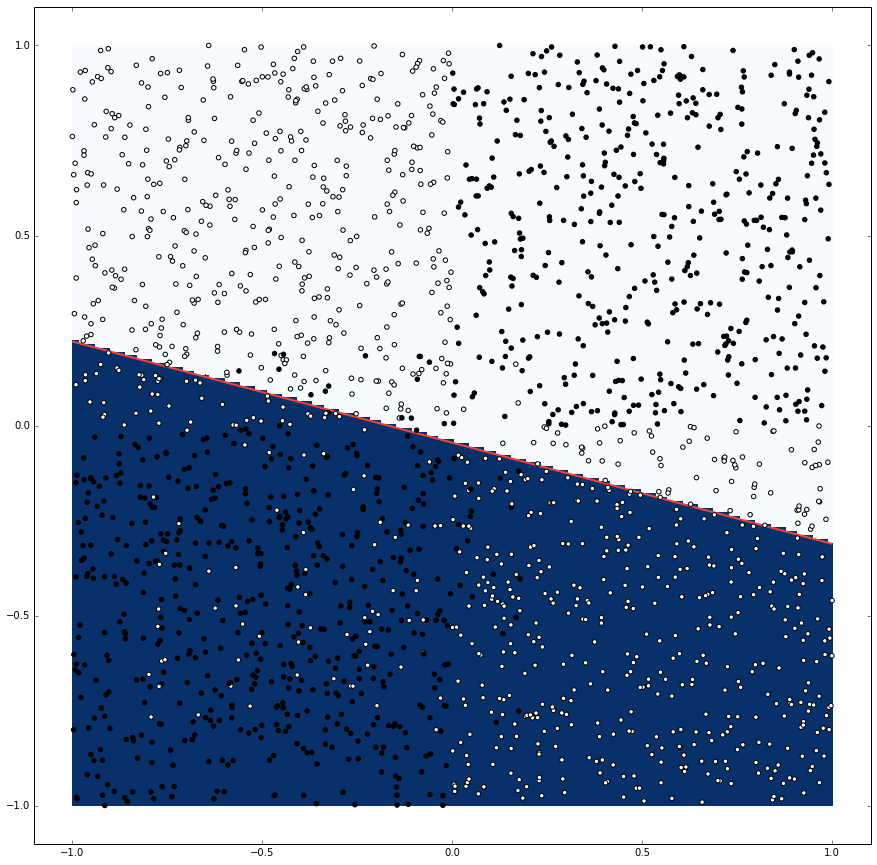

In [5]:
clf_linear = svm.LinearSVC(C = 30)
clf_linear.fit(X_train,Y_train)

get_model_performance(clf_linear,X_train,Y_train,X_test,Y_test,'svm')
plot_classifier(clf_linear,X_train,Y_train,X_test,Y_test,'svm')

<p>Para el entrenamiento de SVM lineal, se realizó el modelo con los datos de entrenamiento, para posteriormente observar el poder de predicción de este con los datos de prueba. Como fue predicho previamente, el modelo es incapaz de generar una categorización óptima siendo un SVM lineal, esto se observa tanto en el gráfico geneardo como en los datos de performance. </p>

<table style="width:40%">
    <tr>
        <th>Iteración</th>
        <th>Precisión</th>
        <th>Recall</th>
        <th>F1</th>
        
    </tr>
    <tr>
        <td>1</td>
        <td>0.56</td>
        <td>0.56</td>
         <td>0.56</td>
    </tr>
     <tr>
        <td>2</td>
        <td>0.34</td>
        <td>0.35</td>
         <td>0.33</td>
    </tr>
     <tr>
        <td>3</td>
        <td>0.44</td>
        <td>0.44</td>
         <td>0.44</td>
    </tr>
     <tr>
        <td>4</td>
        <td>0.24</td>
        <td>0.49</td>
         <td>0.42</td>
    </tr>
     <tr>
        <td>5</td>
        <td>0.76</td>
        <td>0.51</td>
         <td>0.35</td>
    </tr>
     <tr>
        <td>6</td>
        <td>0.26</td>
        <td>0.51</td>
         <td>0.54</td>
    </tr>
     <tr>
        <td>7</td>
        <td>0.61</td>
        <td>0.57</td>
         <td>0.51</td>
    </tr>
     <tr>
        <td>8</td>
        <td>0.51</td>
        <td>0.51</td>
         <td>0.31</td>
    </tr>
     <tr>
        <td>9</td>
        <td>0.31</td>
        <td>0.33</td>
         <td>0.38</td>
    </tr>
     <tr>
        <td>10</td>
        <td>0.76</td>
        <td>0.52</td>
         <td>0.38</td>
    </tr>
     <tr>
        <th>Promedio</th>
        <td>0.479</td>
        <td>0.479</td>
         <td>0.411</td>
    </tr>
</table>

<p>Los datos obtenidos nos indican que: menos de la mitad de los datos extraidos están correctamente clasificados y que de todos los datos correspondientes a una clase, menos de la mitad son extraidos correctamente. F1 Score sirve para complementar la observación previa, obteniendo un valor de 0.411 , relativamente pobre para una máquina de aprendizaje.</p> 

<h3>Análisis SVM Kernel 'Radial Basis Function' </h3>

0.899090909091
0.966
             precision    recall  f1-score   support

         -1       0.99      0.94      0.96       489
          1       0.94      0.99      0.97       511

avg / total       0.97      0.97      0.97      1000



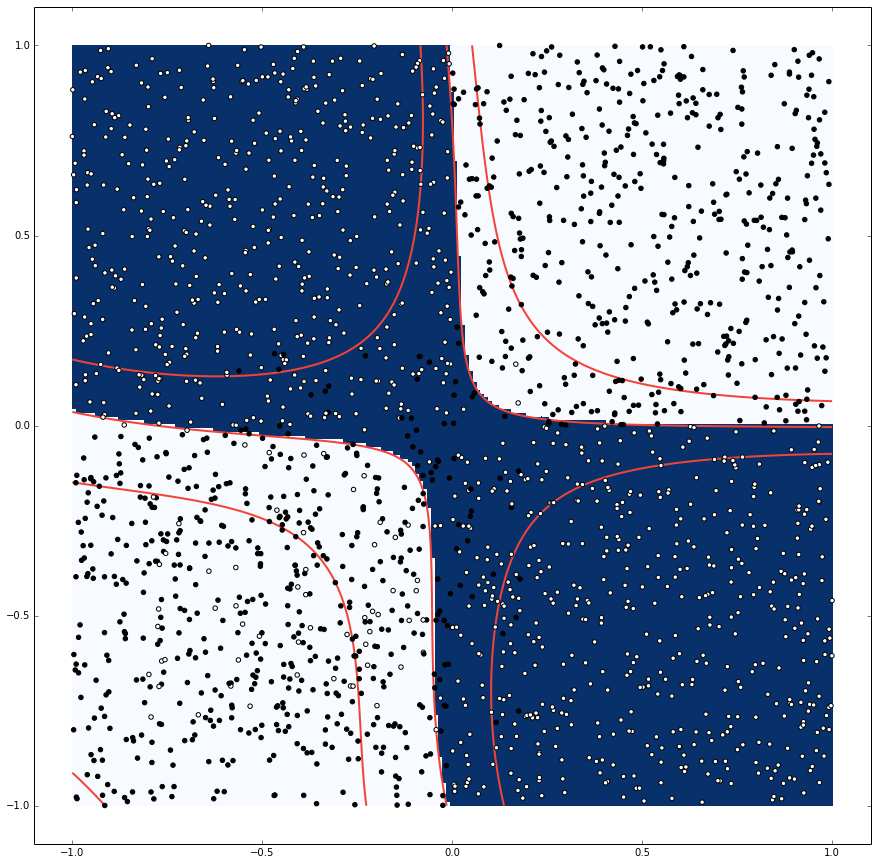

In [6]:
clf_kernel_rbf = SVC(C = 10, kernel = 'rbf')
clf_kernel_rbf.fit(X_train, Y_train)

get_model_performance(clf_kernel_rbf,X_train,Y_train,X_test,Y_test,'svm')
plot_classifier(clf_kernel_rbf,X_train,Y_train,X_test,Y_test,'svm')


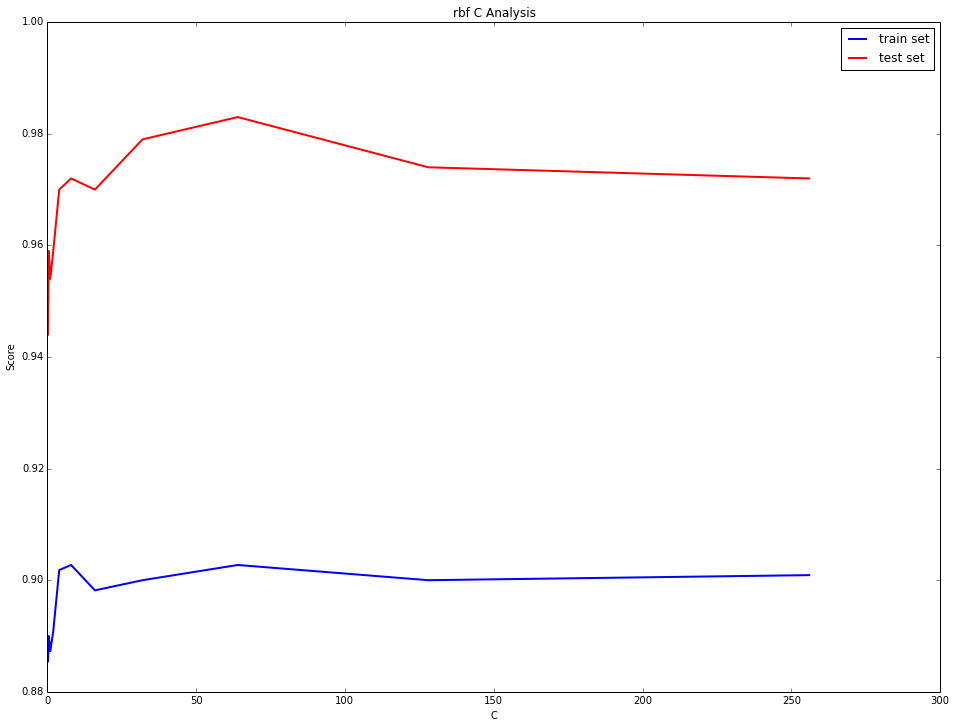

In [33]:
def get_rbf_regularization_plot(X_train, Y_train, X_test, Y_test, kernel):
    train_score = []
    test_score = []
    c_array = []
    for i in range(-2,9):
        c = 2**i
        if kernel == 'rbf':
            clf_kernel = SVC(C = c, kernel = kernel)
            clf_kernel.fit(X_train, Y_train)
        if kernel == 'poly':
            clf_kernel = SVC(C = c, kernel = 'poly', degree = 2, coef0 = 1)
            clf_kernel.fit(X_train, Y_train)
            
        train_score.append(clf_kernel.score(X_train,Y_train))
        test_score.append(clf_kernel.score(X_test,Y_test))
        c_array.append(c)
        
    plt.figure(figsize=(16,12))  
    plt.plot(c_array,train_score,label="train set",linewidth="2")
    plt.plot(c_array,test_score, label="test set",color="red",linewidth="2")
    plt.title( str(kernel) + " C Analysis")
    plt.xlabel("C")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
get_rbf_regularization_plot(X_train, Y_train, X_test, Y_test, 'rbf')

En una máquina SVM , el parámetro $C$ es llamado el <i>parámetro de regularización</i>, el cual genera un "trade-off" entre la rigidez de la clasificación (distancia respecto al hiperplano) y la simpleza de la superficia de toma de desición. Un C relativamente bajo significa que la máquina de clasificación permite mas clasificaciones incorrectas, en donde puede ocurrir <i>Underfitting</i>. Por el otro lado, un C relativamente grande va a buscar clasificar correctamente todos los elementos lo mas preciso posible, es decir se adecua demasiado al set de entrenamiento, por lo que puede ocurrir <i> Overfitting </i>.

En el gráfico observado anteriormente se observa un ligero overffiting pasado el valor $C = 50$ , en donde el Accuracy del set de prueba disminuye.

<h3>Análisis SVM Kernel Polinomial </h3>



0.900909090909
0.977
             precision    recall  f1-score   support

         -1       0.98      0.98      0.98       489
          1       0.98      0.98      0.98       511

avg / total       0.98      0.98      0.98      1000



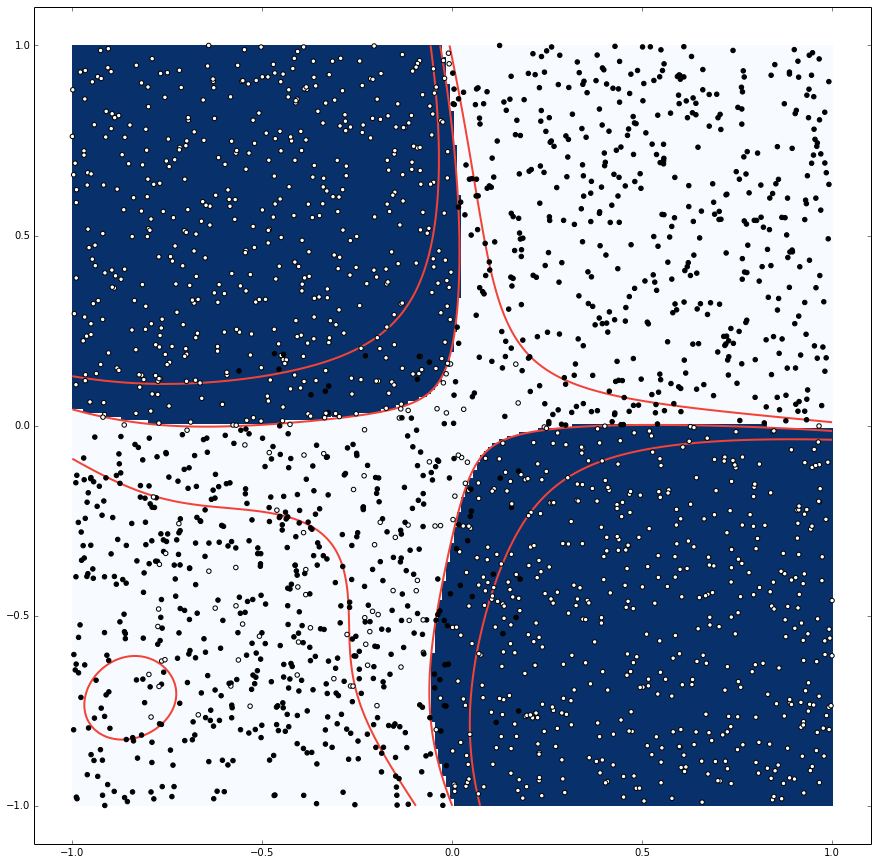

In [7]:
clf_kernel_poly = SVC(C = 10, kernel = 'poly', degree = 5, coef0 = 1)
clf_kernel_poly.fit(X_train, Y_train)

get_model_performance(clf_kernel_poly,X_train,Y_train,X_test,Y_test,'svm')
plot_classifier(clf_kernel_poly,X_train,Y_train,X_test,Y_test,'svm')

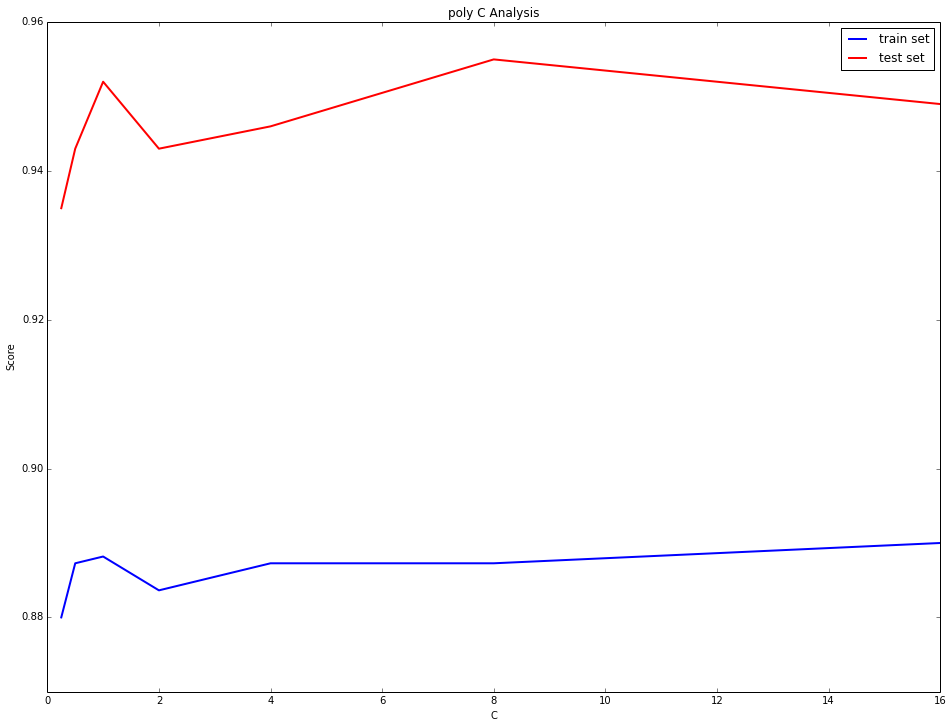

In [32]:
get_rbf_regularization_plot(X_train, Y_train, X_test, Y_test, 'poly')

<img src="Polynomial_Degrees.png" />

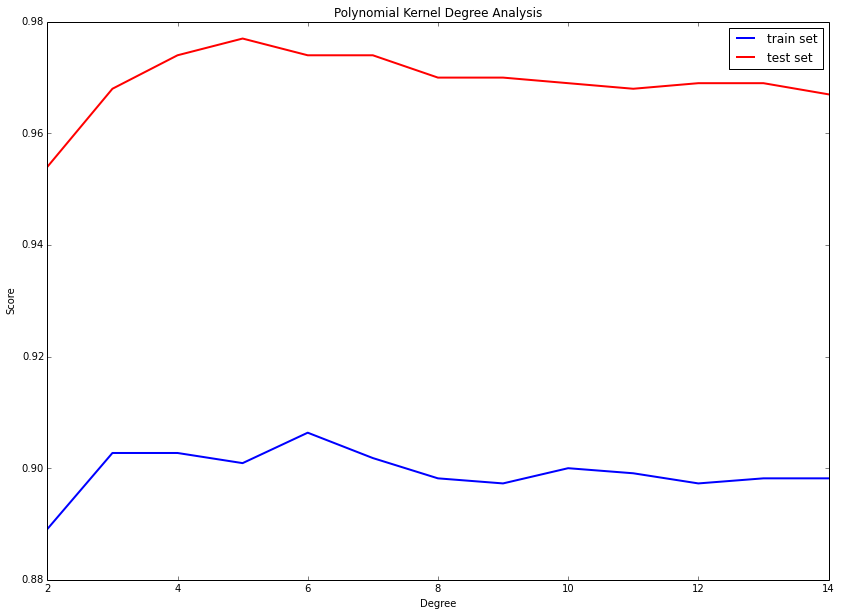

In [48]:
def get_rbf_degree_plot(X_train, Y_train, X_test, Y_test):
    train_score = []
    test_score = []
    degree_array = []
    for i in range(2,15):
         
        clf_kernel = SVC(C = 10, kernel = 'poly', degree = i, coef0 = 1)
        clf_kernel.fit(X_train, Y_train)
        
        degree_array.append(i)   
        train_score.append(clf_kernel.score(X_train,Y_train))
        test_score.append(clf_kernel.score(X_test,Y_test))
    
        
    plt.figure(figsize=(14,10))  
    plt.plot(degree_array,train_score,label="train set",linewidth="2")
    plt.plot(degree_array,test_score, label="test set",color="red",linewidth="2")
    plt.title("Polynomial Kernel Degree Analysis")
    plt.xlabel("Degree")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

get_rbf_degree_plot(X_train, Y_train, X_test, Y_test)

Como se observa en el gráfico, un aumento del grado de polinomio genera un ajuste al dataset de entrenamiento, especialmente al ruido generado, por lo que hay overfitting respecto al score del set de prueba. En general, conforme aumenta el grado del polinomio, el costo de construir la matriz de clasificación se convierte en $ \frac{N^d m^2}{2}$. El uso común de kernel polinomial es de orden 2. Para este ejercicio se observo que el mejor caso se encuentra con un Kernel de grado 5.

<h3> Análisis Red Neuronal </h3>

A continuación se entrenará una red neuronal las cuales consiste en un set de nodos o "neuronas" que trabajan entre sí para producir un input, usando funciones de propagación por cada capa.A continuación se observa una imagen representativa con una capa oculta y 2 nodos en dicha capa.

<img src="NeuralNetwork2.png" /> 

In [26]:
#Es necesario volver a generar el dataset con el parámetro svm = False
X_train,Y_train,X_test,Y_test = do_XOR(svm = False)

n_h = 1
model = Sequential()

model.add(Dense(1, input_dim=X_train.shape[1], init='uniform', activation='sigmoid'))
model.compile( optimizer = SGD( lr = 1 ), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit( X_train, Y_train, nb_epoch = 50, batch_size = 100, verbose = 1)
scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]
scores = model.evaluate(X_train, Y_train)
train_acc = scores[1]


Epoch 1/50
1100/1100 [==============================] - 0s - loss: 0.6943 - acc: 0.5155     
Epoch 2/50
1100/1100 [==============================] - 0s - loss: 0.6921 - acc: 0.4718     
Epoch 3/50
1100/1100 [==============================] - 0s - loss: 0.6924 - acc: 0.4673     
Epoch 4/50
1100/1100 [==============================] - 0s - loss: 0.6920 - acc: 0.5527     
Epoch 5/50
1100/1100 [==============================] - 0s - loss: 0.6941 - acc: 0.4936     
Epoch 6/50
1100/1100 [==============================] - 0s - loss: 0.6927 - acc: 0.5255     
Epoch 7/50
1100/1100 [==============================] - 0s - loss: 0.6920 - acc: 0.5364     
Epoch 8/50
1100/1100 [==============================] - 0s - loss: 0.6925 - acc: 0.4927     
Epoch 9/50
1100/1100 [==============================] - 0s - loss: 0.6925 - acc: 0.5191     
Epoch 10/50
1100/1100 [==============================] - 0s - loss: 0.6921 - acc: 0.5509     
Epoch 11/50
1100/1100 [==============================] - 0s - loss: 0

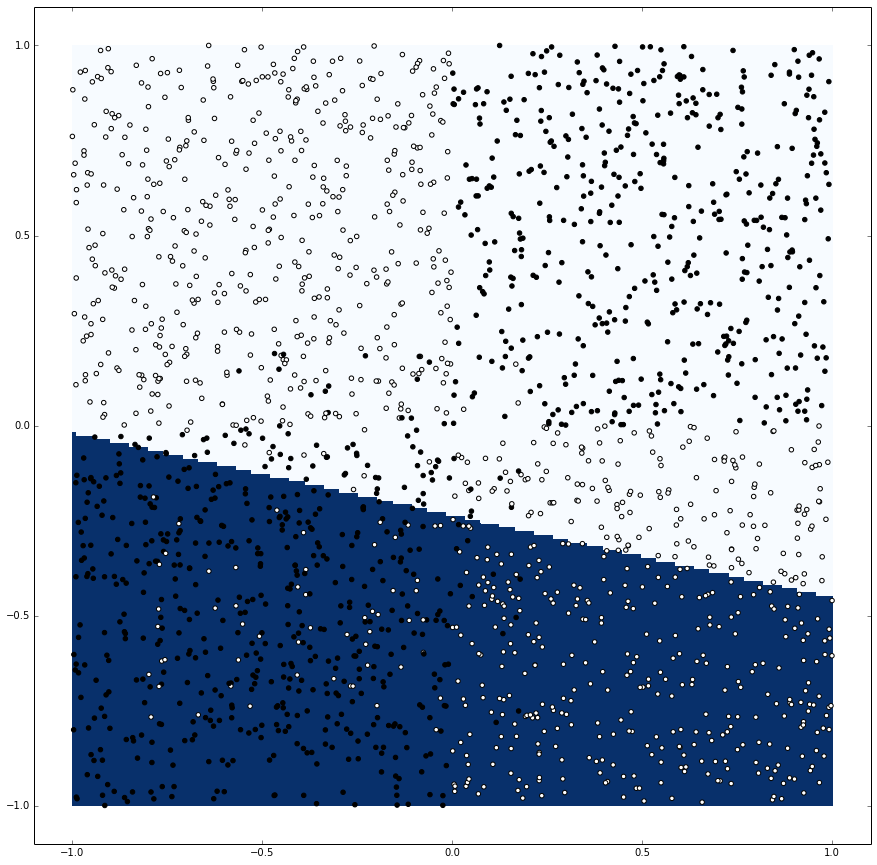

 Training Accuracy: 0.480000000217
 Test Accuracy: 0.427


In [115]:
plot_classifier(model,X_train,Y_train, X_test, Y_test, 'ann')
print " Training Accuracy: " + str(train_acc)
print " Test Accuracy: " + str(test_acc)

Como se observa, una red neuronal sin capa oculta solo puede generar una linea de clasificación, resultante poco efectivo para un problema XOR, al igual que un SVM lineal, es incapaz de clasificar la mitad de los atributos, con un Test Accuracy de $0.427$. Parte de esta tendencia se atribuye también al ruido generado en el set de entrenamiento, el cual no se encuentra en el set de prueba.

In [30]:
n_h = 32
model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))

model.compile( optimizer = SGD( lr = 1 ), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit( X_train, Y_train, nb_epoch = 50, batch_size = 100, verbose = 1)
model.fit( X_train, Y_train, nb_epoch = 50, batch_size = 100, verbose = 1)

scores = model.evaluate(X_train, Y_train)
train_acc = scores[1]

scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]



Epoch 1/50
1100/1100 [==============================] - 0s - loss: 0.6934 - acc: 0.5082     
Epoch 2/50
1100/1100 [==============================] - 0s - loss: 0.6894 - acc: 0.5391     
Epoch 3/50
1100/1100 [==============================] - 0s - loss: 0.6772 - acc: 0.6427     
Epoch 4/50
1100/1100 [==============================] - 0s - loss: 0.6469 - acc: 0.7464     
Epoch 5/50
1100/1100 [==============================] - 0s - loss: 0.5837 - acc: 0.8036     
Epoch 6/50
1100/1100 [==============================] - 0s - loss: 0.5034 - acc: 0.8309     
Epoch 7/50
1100/1100 [==============================] - 0s - loss: 0.4267 - acc: 0.8618     
Epoch 8/50
1100/1100 [==============================] - 0s - loss: 0.3847 - acc: 0.8664     
Epoch 9/50
1100/1100 [==============================] - 0s - loss: 0.3558 - acc: 0.8718     
Epoch 10/50
1100/1100 [==============================] - 0s - loss: 0.3363 - acc: 0.8791     
Epoch 11/50
1100/1100 [==============================] - 0s - loss: 0

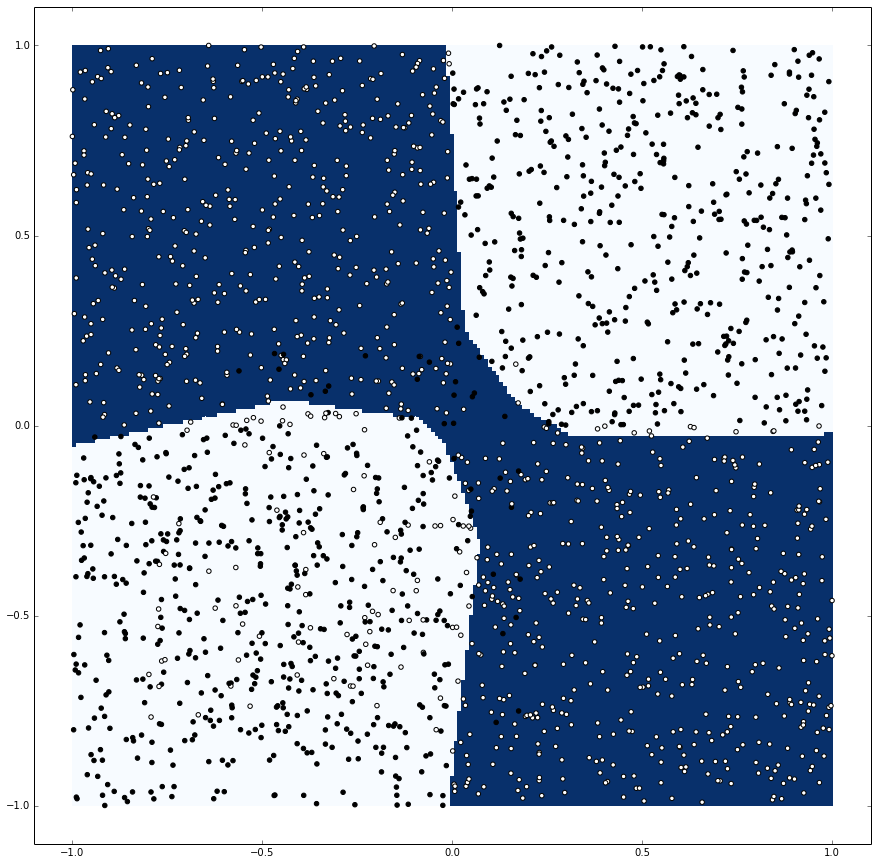

Train Accuraccy: 0.894545454545
Test Accuraccy: 0.969


In [31]:
#Mejor Resultado con 32 neuronas
plot_classifier(model,X_train,Y_train, X_test, Y_test, 'ann')
print "Train Accuraccy: " + str(train_acc)
print "Test Accuraccy: " + str(test_acc)

<img src="Neural_Network.png">

A continuación se observa los gráficos para una cantidad de neuronas = [2,4,16,32] respectivamente. Para los últimos 2 casos la diferencia en la selección de clases es parecida, no hay gran diferencia en el accuracy pero si en el tiempo de ejecución. Es un caso especial la red neuronal con 2 neuronas, dado que este suele caer en óptimos locales y no siempre hay una presición óptima. El gráfico mostrado representa el mejor óptimo posible con un Accuracy de $0.9121$

<h3> Análisis Árbol Clasificador </h3>


0.541818181818
0.489
             precision    recall  f1-score   support

         -1       0.48      0.67      0.56       489
          1       0.50      0.32      0.39       511

avg / total       0.49      0.49      0.47      1000



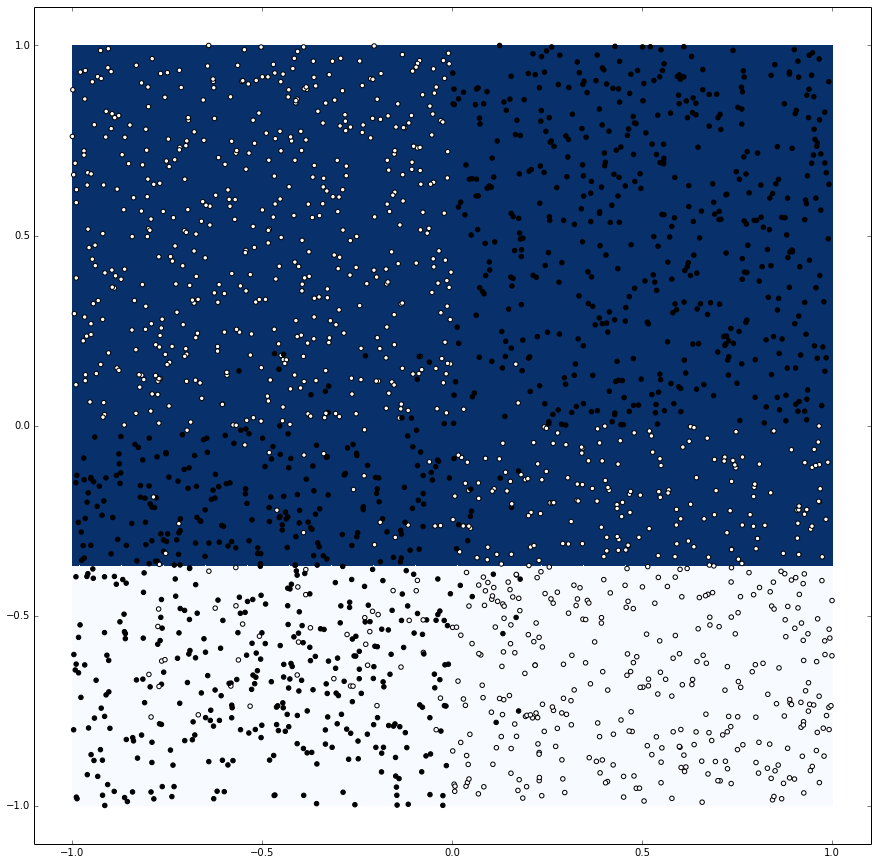

1


In [128]:
clf_tree = Tree ( criterion = 'gini', splitter = 'best', random_state = 0 , max_depth = 1)
clf_tree.fit( X_train , Y_train )

get_model_performance( clf_tree , X_train, Y_train, X_test, Y_test, 'tree')
plot_classifier( clf_tree , X_train , Y_train , X_test , Y_test , 'tree')


Un <b>Stump Desicion Tree</b> es un árbol que toma una sola desición, el cual resula poco efectivo para el dataset ya que consiste en separar linealmente y conlleva a la misma precisión que en un SVM Lineal. Es importante destacar que la linea de clasificación está mas bajo que el centro del dataset debido a la intervención del ruido generado.

0.909090909091
0.99
             precision    recall  f1-score   support

         -1       0.99      0.99      0.99       489
          1       0.99      0.99      0.99       511

avg / total       0.99      0.99      0.99      1000



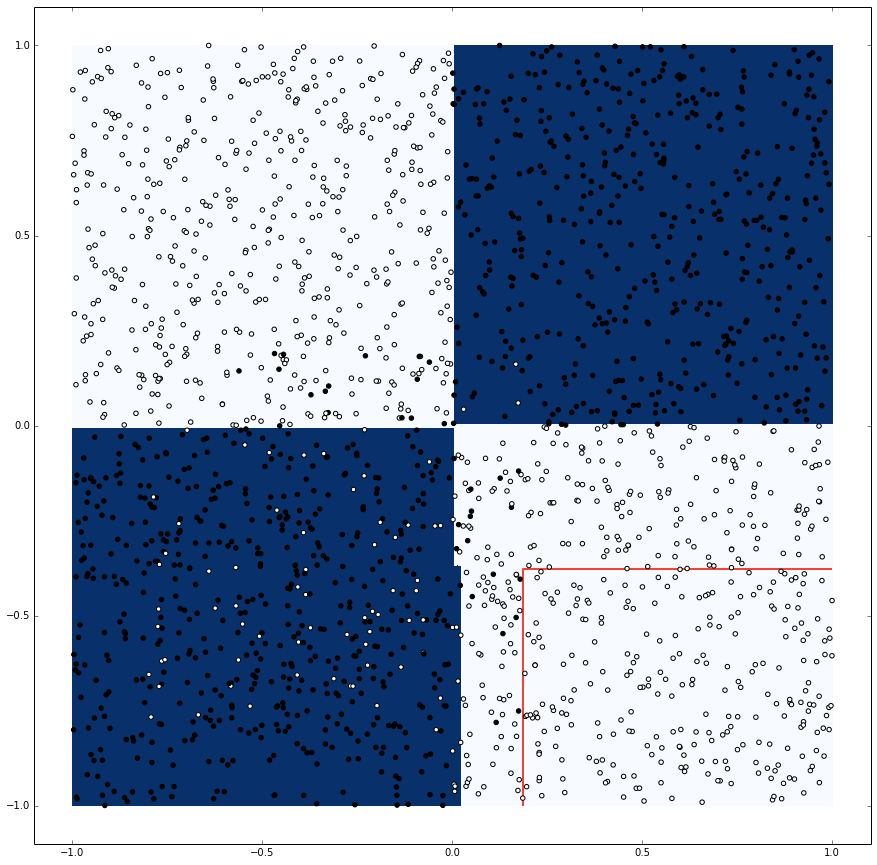

In [8]:
clf_tree = Tree ( criterion = 'gini', splitter = 'best', random_state = 0 , max_depth = 3)
clf_tree.fit( X_train , Y_train )

get_model_performance( clf_tree , X_train, Y_train, X_test, Y_test, 'tree')
plot_classifier( clf_tree , X_train , Y_train , X_test , Y_test , 'tree')

1.0
0.92
             precision    recall  f1-score   support

         -1       0.93      0.90      0.92       489
          1       0.91      0.94      0.92       511

avg / total       0.92      0.92      0.92      1000



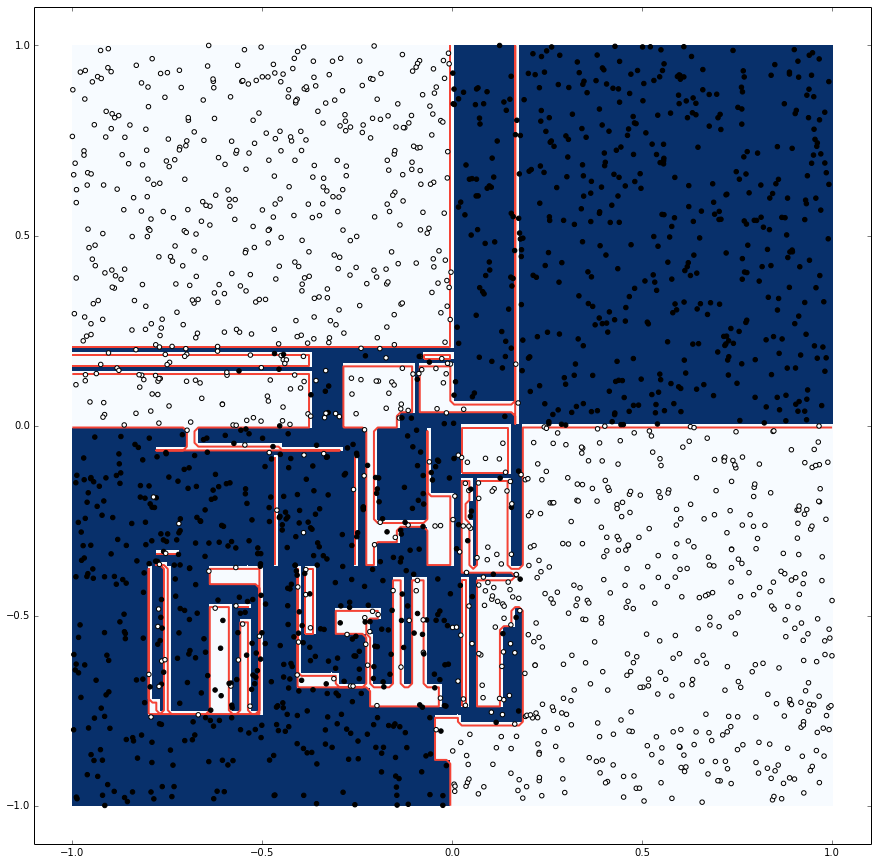

In [8]:
clf_tree = Tree ( criterion = 'gini', splitter = 'best', random_state = 0 , max_depth = 20)
clf_tree.fit( X_train , Y_train )

get_model_performance( clf_tree , X_train, Y_train, X_test, Y_test, 'tree')
plot_classifier( clf_tree , X_train , Y_train , X_test , Y_test , 'tree')

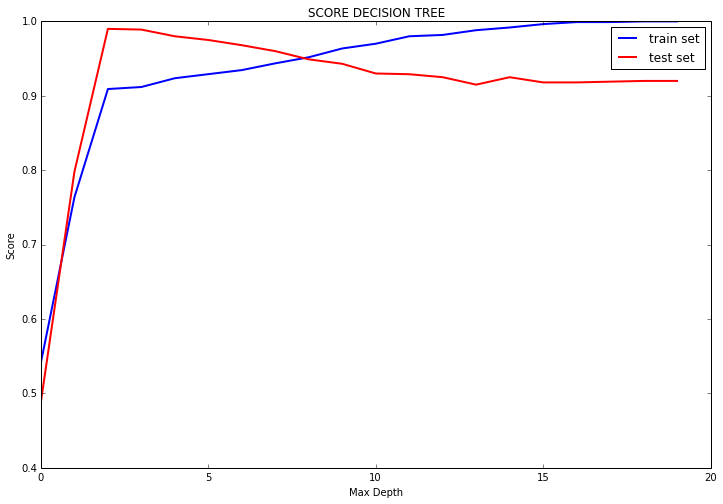

In [7]:
def get_train_set_treeplot(X_train, Y_train, X_test, Y_test):
    train_score = []
    test_score = []
    for i in range(1,21):
        clf_tree = Tree ( criterion = 'gini', splitter = 'best', random_state = 0 , max_depth = i)
        clf_tree.fit( X_train , Y_train )
        
        train_score.append(clf_tree.score(X_train,Y_train))
        test_score.append(clf_tree.score(X_test,Y_test))
        
    plt.figure(figsize=(12,8))  
    plt.plot(train_score,label="train set",linewidth="2")
    plt.plot(test_score, label="test set",color="red",linewidth="2")
    plt.title("SCORE DECISION TREE")
    plt.xlabel("Max Depth")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
get_train_set_treeplot(X_train, Y_train, X_test, Y_test)       
        
        

El mejor Score se obtiene con un arbol de profundidad máxima de $3$ . El Score del árbol en el Testing set va disminuyendo conforme se aumenta la profundidad máxima del árbol, dado que se sobreajusta al training set, el cual tiene un ruido que finalmente conlleva a errores en la clasificación con otros datasets. Esto puede observarse bien en la imagen, que genera sub nucleos para clasificar lo mas correctamente posible el ruido generado en el set de entrenamiento.

<h3>CONCLUSIONES </h3>

No todos los métodos de clasificación pueden generar un corte no lineal para distintos tipos de datasets, fenomeno que es mas frecuente conforme aumenta la dimensionalidad, por lo que es necesario realizar un análisis de cual es el mejor algoritmo para determinado problema. Otro aspecto importante es como están distribuidos los datos, dado que , como se vio con la intervención del ruido, estos afectan el como se ajusta el modelo, por lo que es importante ir variando parámetros para aumentar o disminuir la sensibilidad del modelo en relación a la precisión de este (trade-off).

Para este casó , las mejores resultados se obtuvieron con un árbol de clasificación con profundidad máxima de 3, con un score de $0.99$ y un árbol de clasificación con 16 neuronas (se escogen 16 neuronas dado que al usar 32 neuronas aumenta un poco la precisión, pero el tiempo de compilación aumenta considerablemente.